## Setting up Pyspark in IBM Watson Studio

In [1]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8MB 192kB/s  eta 0:00:01                    | 35.2MB 5.6MB/s eta 0:00:33��█████▏                      | 62.6MB 5.6MB/s eta 0:00:28
     |████████████████████████████████| 204kB 61.0MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [2]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

### Setting up the connection to a Spark Cluster
This is done with the SparkContext, which is the main entry point for Spark functionality. [docs](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext)

In [3]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

The main entry for eql.functionality in PySpark is set with the sql.SparkSession. This enables SQL like syntax to work with the spark dataframes. 

In [4]:
spark = SparkSession.builder.getOrCreate()

### Getting the data
The washing machine sensor data is used here, which is obtained from the coursera IBM Datascience course. The data is grabbed from a web link and then a dataframe is created outof it using spark.

In [5]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-06-13 09:32:18--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-06-13 09:32:18--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-06-13 09:32:18--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet [fo

This creates a Resilient Distributed Dataset (RDD), a basic dataframe abstraction in Spark.

In [6]:
df = spark.read.parquet('washing.parquet')

#### Checking how many rows the data contains.

* This can be done directly by using the methods on the dataframe

In [7]:
df.count()

2058

* Or can also be done using the SQL format by creating a table view of the df 

In [12]:
df.createOrReplaceTempView("washing")
spark.sql("SELECT COUNT(*) FROM washing").show()

+--------+
|count(1)|
+--------+
|    2058|
+--------+



#### Viewing the data

* .show() method can be called on the SQL table view that has been created.

In [13]:
spark.sql("SELECT * FROM washing").show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

* Or .show() can be called directly on the dataframe

In [19]:
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

### Data Visualization using Spark Dataframe

matplotlib or any plotting library in python can be used for plotting the data from spark dataframes. But, since spark dataframes are usually very large and donot fit onto one machine. Infact this is the reason behing using Spark. So all of the data cannot be plotted at once since any plotting library runs on single machine, therefore the data has to be sampled to be able to accommodate a subset of the complete data on one single machine to plot it.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

##### Box plot

The SQL commands can be used to select the required columns from the whole data. 

In [21]:
result = spark.sql("select voltage from washing where voltage is not null")

In [22]:
type(result)

pyspark.sql.dataframe.DataFrame

As seen the resulting object from the SQL selection is also a spark dataframe. Now in order to plot the selected data, the data has to be converted to numpy arrays of python lists as shown below. 

* '.sample(withReplacement, fraction)' is used to sample desired amount of data
* '.collect()' is used to return a list of the elements contained in the sampled dataframe

In [25]:
result_array = result.rdd.map(lambda row : row.voltage).sample(False,0.1).collect()

In [26]:
result_array

[236,
 226,
 232,
 230,
 229,
 236,
 234,
 222,
 228,
 229,
 237,
 221,
 236,
 252,
 255,
 226,
 234,
 223,
 232,
 239,
 225,
 236,
 232,
 229,
 231,
 240,
 235,
 229,
 235,
 225,
 220,
 224,
 221,
 257,
 220]

Now any plotting function can be called directly on the generated array

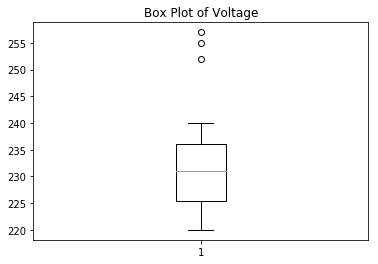

In [29]:
plt.boxplot(result_array)
plt.title("Box Plot of Voltage")
plt.show()

##### Time series plot

To plot a time series plot, we need to extract the time column and the voltage column into lists. The same steps of extracting the required columns with SQL, sampling and converting into lists is followed as shown below. 

In [30]:
result = spark.sql("select voltage,ts from washing where voltage is not null order by ts asc")
result_rdd = result.rdd.sample(False,0.1).map(lambda row : (row.ts,row.voltage))

Since two columns are selected, each row now is a tuple of two elements and therefore can be indexed accordingly to make two different arrays

In [31]:
result_array_ts = result_rdd.map(lambda ts_voltage: ts_voltage[0]).collect()
result_array_voltage = result_rdd.map(lambda ts_voltage: ts_voltage[1]).collect()

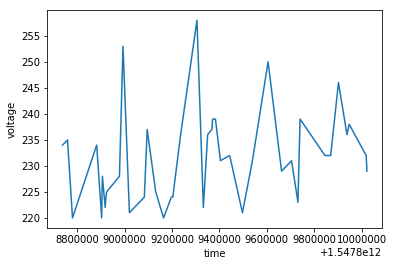

In [32]:
plt.plot(result_array_ts,result_array_voltage)
plt.xlabel("time")
plt.ylabel("voltage")
plt.show()

##### Histogram

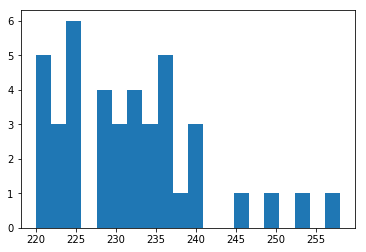

In [36]:
plt.hist(result_array_voltage, bins=20)
plt.show()